# xAI Wake Classifier - Inference

## Required data (run to download the xAI Wakes dataset yet)
* For the .csv with the target values for training and a set of pretrained weights, go to: https://drive.google.com/drive/folders/1CUIQy77qIsx2vIdJB7D95UEzCv5_YZDL?usp=sharing
* For the dataset, run the following code:

In [ ]:
import requests
from tqdm import tqdm

def download_file(url, filename):
    """
    Download a file from the specified URL and save it locally.
    """
    # Send a GET request to the URL
    response = requests.get(url, stream=True)

    # Total size in bytes
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024  # 1 Kibibyte

    with open(filename, 'wb') as file, tqdm(
        total=total_size, unit='iB', unit_scale=True
    ) as bar:
        for data in response.iter_content(block_size):
            bar.update(len(data))
            file.write(data)

# URL of the file to be downloaded
url = "https://zenodo.org/records/10018939/files/xAIWakes.zip?download=1"

# Local filename to save the downloaded file
filename = "xAIWakes.zip"

# Download the file
download_file(url, filename)

print(f"Downloaded '{filename}'.")

* Extract the downloaded dataset:

In [ ]:
import zipfile

# Specify the path to the zip file and the extraction directory
zip_path = 'xAIWakes.zip'
extract_to = 'xAIWakes'

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

* Download pretrained weights using the following code or directly from https://drive.google.com/file/d/1IS1Ee1Wq6a5NYhkZ9Now9ChoRwNcF9WS/view?usp=drive_link

In [17]:
import gdown

def download_file_from_drive(drive_link, output_file):
    gdown.download(drive_link, output_file, quiet=False)
    print("File downloaded")

# Example usage:
drive_link = "https://drive.google.com/uc?export=download&id=1IS1Ee1Wq6a5NYhkZ9Now9ChoRwNcF9WS"
output_file = 'epoch=19-step=140.ckpt'

download_file_from_drive(drive_link, output_file)

Downloading...
From (uriginal): https://drive.google.com/uc?export=download&id=1IS1Ee1Wq6a5NYhkZ9Now9ChoRwNcF9WS
From (redirected): https://drive.google.com/uc?export=download&id=1IS1Ee1Wq6a5NYhkZ9Now9ChoRwNcF9WS&confirm=t&uuid=83e43a90-3a54-4bf7-911a-265d574d6a6d
To: C:\Users\andre\PycharmProjects\xAI_Wake_Classifier_notebook\epoch=19-step=140.ckpt
100%|██████████| 403M/403M [01:00<00:00, 6.71MB/s] 

File downloaded


## Imports

In [5]:
import torch
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from PIL import Image
from torch import nn
from pathlib import Path 
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import imageio

* Function to load and tranform imagery

In [6]:
def read_img(idx):
    
    def correct_dim(img):
        # If the image is not already in grayscale, convert it
        if len(img.shape) == 3 and img.shape[2] == 3:  # Assuming the image is RGB
            img_gray = img[:, :, 0]
        else:
            img_gray = img
        return img_gray

    resize_transform = transforms.Resize((256,256), antialias=True)

    b2 = [x for x in Path('xAIWakes/xAIWakes/B2').glob('**/*') if x.is_file()]
    b3 = [x for x in Path('xAIWakes/xAIWakes/B3').glob('**/*') if x.is_file()]
    b4 = [x for x in Path('xAIWakes/xAIWakes/B4').glob('**/*') if x.is_file()]
    b8 = [x for x in Path('xAIWakes/xAIWakes/B8').glob('**/*') if x.is_file()]

    # Exclude unwanted indices
    exclude_indices = [4, 80, 84, 87]  # Because B2 no_wake has some images in excess
    b2 = [b2[i] for i in range(len(b2)) if i not in exclude_indices] # Because B2 no_wake has some images in excess
    
    b2_idx = b2[idx]
    b3_idx = b3[idx]
    b4_idx = b4[idx]
    b8_idx = b8[idx]

    # Load the corresponding image of every band
    im_b2 = imageio.imread(b2_idx)
    im_b3 = imageio.imread(b3_idx)
    im_b4 = imageio.imread(b4_idx)
    im_b8 = imageio.imread(b8_idx)

    # Correct the dimensions
    im_b2 = correct_dim(im_b2)
    im_b3 = correct_dim(im_b3)
    im_b4 = correct_dim(im_b4)
    im_b8 = correct_dim(im_b8)
    
    # Convert NumPy arrays to PIL Images
    im_b2 = Image.fromarray(im_b2)
    im_b3 = Image.fromarray(im_b3)
    im_b4 = Image.fromarray(im_b4)
    im_b8 = Image.fromarray(im_b8)
    
    # Apply resizing transformation
    im_b2 = resize_transform(im_b2)
    im_b3 = resize_transform(im_b3)
    im_b4 = resize_transform(im_b4)
    im_b8 = resize_transform(im_b8)
    
    im_stack = np.stack((im_b2, im_b3, im_b4, im_b8), axis=0)
    #print("CHECK:", im_stack.shape)
    return im_stack.astype(np.float32)


* The classification model 

In [7]:
class WakeClassifier(nn.Module):
    def __init__(self, num_classes = 2):
        super().__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False) # bias=False because bn is applied
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)

        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))

        # Dropout
        self.drop = nn.Dropout(p=0.4)

        # Batch normalization
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 32 * 32, 512)  # Adjust input size based on your image dimensions
        self.fc2 = nn.Linear(512, num_classes)  # Output layer with 2 classes
        
    def forward(self, x):
        # Convolutional layers with ReLU activation, batch normalization, and max pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # Flatten before fully connected layers
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.drop(self.fc2(x))
        return x

## Inference

Valid indexes for xAIWakes are from 1 to 269.


Input index:  168


1


C:\Users\andre\AppData\Local\Temp\ipykernel_18204\2379662853.py:28: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im_b2 = imageio.imread(b2_idx)
C:\Users\andre\AppData\Local\Temp\ipykernel_18204\2379662853.py:29: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im_b3 = imageio.imread(b3_idx)
C:\Users\andre\AppData\Local\Temp\ipykernel_18204\2379662853.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.i

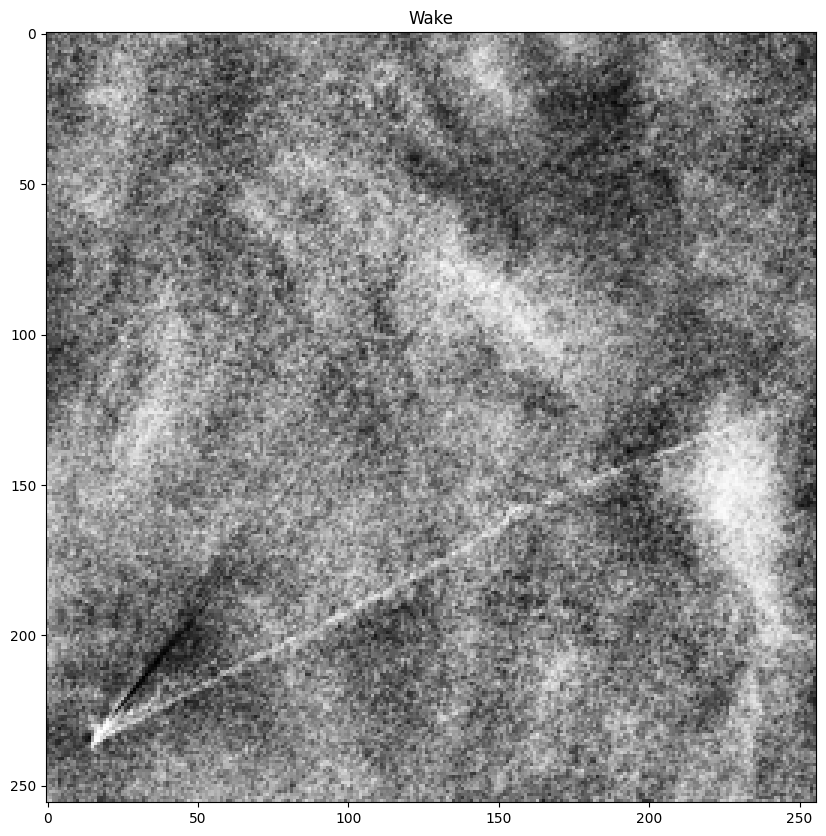

In [19]:
# Initialize the model
model = WakeClassifier(num_classes=2)

# Path to load weights
ckpt_path = 'epoch=19-step=140.ckpt'

# Load the model weights
checkpoint = torch.load(ckpt_path, map_location=torch.device('cpu'))
state_dict = checkpoint['state_dict']

# Remove unexpected keys
expected_keys = []
for name, param in model.named_parameters():
    expected_keys.append(name)

unexpected_keys = list(set(state_dict.keys()) - set(expected_keys))
for key in unexpected_keys:
    del state_dict[key]

# Load only the weights
model.load_state_dict(state_dict, strict=False)
model.eval()

# Define input data transformations
resize_transform = transforms.Resize((256,256), antialias=True)

# Read the input image
idx = -1
while idx < 1 or idx > 269:
    try:
        print("Valid indexes for xAIWakes are from 1 to 269.")
        idx = int(input("Input index: "))
        if idx < 1 or idx > 269:
            print("Invalid index. Please enter a value between 1 and 269.")
    except ValueError:
        print("Invalid input. Please enter a valid integer.")

# Uncomment the line below, and comment the while loop, if you want to set a specific index (e.g., idx = 4)
# idx = 4

input_data = read_img(idx=idx)

# Convert to Tensors
input_tensor = torch.from_numpy(input_data)
input_tensor = input_tensor.float()

# Normalize the image data
input_tensor = resize_transform(input_tensor)
input_tensor = input_tensor.unsqueeze(0)

# Use the model for inference
with torch.no_grad():
    out = model(input_tensor)

# Get the predicted class
out_log = torch.argmax(out, dim=1)

# Print the predicted class
print(out_log.item())

def plot_output(input_tensor, out_log):
    im = input_tensor.cpu()[0, 0, :, :]  # Move the tensor to CPU before indexing
    plt.figure(figsize=(10, 10))
    title = 'Wake' if out_log else 'Clutter'
    plt.title(title)
    plt.imshow(im.numpy(), cmap='gray')
    plt.show()
    
plot_output(input_tensor=input_tensor, out_log=out_log.item())